## Import necessary libraries

In [ ]:
#import necessary libraries
from pathlib import Path
import torch
import lightning as L
from app.models.effdet_model import EffDetLModel
from app.config.config import config
from app.utils import custom_collate, create_custom_data_loader
from app.model_loader import load_model, postprocess_image_output, preprocess_image, postprocess_images_outputs, make_prediction
from effdet.data import DetectionDatset
from effdet.data.parsers import CocoParserCfg, create_parser
from effdet.data.transforms import resolve_fill_color, ImageToNumpy, Compose, ResizePad

import matplotlib.pyplot as plt


batch_size = 8


loaded_model = load_model()

Model loaded.


In [2]:
import io
from PIL import Image
test_img_bytes = "datasets/palm-oil-2/test/frame1-23-_png_jpg.rf.ec98ce935352d90aeb8ae397522d9af6.jpg"

with open(test_img_bytes, "rb") as f:
    image_bytes = f.read()

type(image_bytes)

img = Image.open(io.BytesIO(image_bytes)).convert("RGB")

img_size = (512,512)
fill_color = resolve_fill_color("mean", config.IMAGENET_DEFAULT_MEAN)


image_tfl = [ResizePad(target_size=img_size, interpolation="bilinear", fill_color=fill_color), ImageToNumpy(),]
transform = Compose(image_tfl)


img = torch.from_numpy(transform(img, {})[0]).unsqueeze(0).float().to("cuda")


loaded_model = EffDetLModel.load_from_checkpoint("lightning_logs/version_70/checkpoints/epoch=14-step=5460.ckpt", bench_task = "predict")
# loaded_model = EffDetLModel.load_from_checkpoint("lightning_logs/version_70/checkpoints/epoch=14-step=5460.ckpt", model_architecture = model_architecture, num_classes = num_classes, bench_task = "predict", lr = 0.0002, batch_size = 8)
loaded_model.to("cuda")
loaded_model.eval()

#Predict using model
preds = loaded_model(img)



self.model_predict called


## Set up Dataset and Dataloader

Note that data loader targets are in the format yxyx whereas model output is in the format xyxy. Torch metrics require xyxy format. When logging metrics, dataloader y values need to be converted before being fed into map computation. Note also impact on bounding boxes.
 

In [ ]:
# ann_file = "_annotations.coco.json"
train_ann_file = "datasets/palm-oil-2/train/_annotations.coco.json"
train_data_dir = Path("datasets/palm-oil-2/train")
validation_ann_file = "datasets/palm-oil-2/valid/_annotations.coco.json"
validation_data_dir = Path("datasets/palm-oil-2/valid")

#set up parser config to be used in DetectionDataset instantiation

train_parser_cfg = CocoParserCfg(
    ann_filename=train_ann_file,
    has_labels=True
)


train_parser = create_parser("coco",cfg = train_parser_cfg)

train_dataset = DetectionDatset(
    data_dir = train_data_dir,
    parser=train_parser
)


#set up parser config to be used in DetectionDataset instantiation

validation_parser_cfg = CocoParserCfg(
    ann_filename=validation_ann_file,
    has_labels=True
)

validation_parser = create_parser("coco",cfg = validation_parser_cfg)

validation_dataset = DetectionDatset(
    data_dir = validation_data_dir,
    parser=validation_parser
)






loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
#Create train and validation loader. 
train_loader = create_custom_data_loader(train_dataset, input_size=config.image_size, is_training=True, batch_size=batch_size, num_workers = 2, collate_fn = custom_collate)
validation_loader = create_custom_data_loader(train_dataset, input_size=config.image_size, is_training=False,batch_size=batch_size, num_workers = 2, collate_fn = custom_collate)

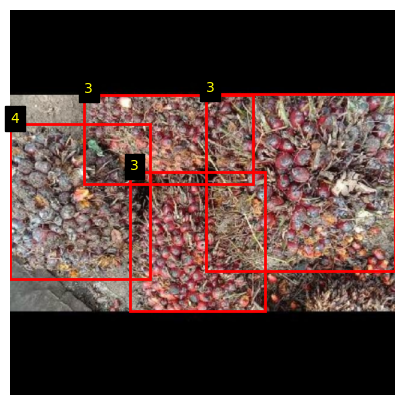

In [ ]:


imgs, targets = next(iter(train_loader))
img = imgs[0].cpu().detach()         # tensor shape (C, H, W)
img = img.permute(1, 2, 0).numpy()   # now shape (H, W, C)

plt.figure(figsize=(5,5))
plt.imshow(img.astype("uint8"))
plt.axis("off")

# If you'd like to overlay bounding boxes from your target:
boxes = targets["bbox"][0]  # first image’s boxes, shape (N,4)
labels = targets["cls"][0]  # corresponding labels


for i, box in enumerate(boxes):
    if box[0] < 0:             # assuming `-1` means padded/no box
        continue
    y_min, x_min, y_max, x_max = box
    # draw rectangle
    rect = plt.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min,
                         fill=False, color='red', linewidth=2)
    plt.gca().add_patch(rect)
    plt.gca().text(x_min, y_min-2, f"{labels[i].item()}",
                   color='yellow', fontsize=10, backgroundcolor="black")

## Model Training

In [7]:
# #Uncomment when training. 

# trainer = L.Trainer(accelerator="gpu", max_epochs = 15)
# model_train = EffDetLModel(model_architecture=config.model_architecture, num_classes=config.num_classes)
# trainer.fit(model_train, train_dataloaders=train_loader, val_dataloaders=validation_loader)


## Inference Example

In [7]:
import matplotlib.pyplot as plt

img_idx = 5

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

#retrieve single image from validation loader. 
next(iter(validation_loader))
imgs, targets = next(iter(validation_loader))

imgs = imgs.to(device)

#create and load model. 
loaded_model = EffDetLModel.load_from_checkpoint("lightning_logs/version_70/checkpoints/epoch=14-step=5460.ckpt", bench_task = "predict")
# loaded_model = EffDetLModel.load_from_checkpoint("lightning_logs/version_70/checkpoints/epoch=14-step=5460.ckpt", model_architecture = model_architecture, num_classes = num_classes, bench_task = "predict", lr = 0.0002, batch_size = 8)
loaded_model.to("cuda")
loaded_model.eval()

#Predict using model
preds = loaded_model(imgs)

self.model_predict called


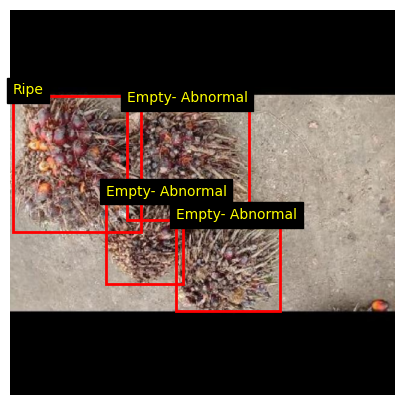

In [8]:
#move image to cpu. Change format to meet plt reqs. 
img = imgs[img_idx].cpu().detach()         # tensor shape (C, H, W)
img = img.permute(1, 2, 0).numpy()   # now shape (H, W, C)

plt.figure(figsize=(5,5))
plt.imshow(img.astype("uint8"))
plt.axis("off")

pred = preds[img_idx].detach().cpu() 

detections = postprocess_image_output(pred)


for detection in detections:
    
    x_min, y_min, x_max, y_max = detection["bbox"]
    rect = plt.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min,
                         fill=False, color='red', linewidth=2)
    plt.gca().add_patch(rect)
    plt.gca().text(x_min, y_min-2, f"{detection["class_name"]}",
                   color='yellow', fontsize=10, backgroundcolor="black")



## Inference example 2 (Using image_bytes rather than dataloader)

Model loaded.
self.model_predict called


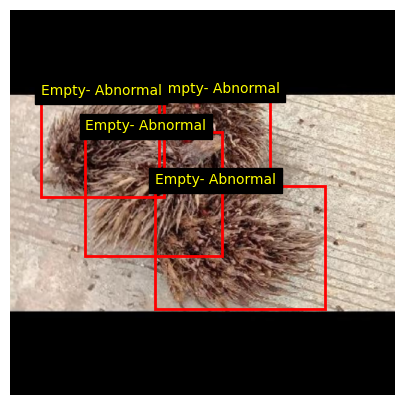

In [10]:
import io
from PIL import Image
import matplotlib.pyplot as plt

#Make predictions with model
test_img_bytes = "datasets/palm-oil-2/test/frame1-23-_png_jpg.rf.ec98ce935352d90aeb8ae397522d9af6.jpg"

with open(test_img_bytes, "rb") as f:
    image_bytes = f.read()
model = load_model()
detections = make_prediction(model, image_bytes)





#Setting up showing of image. 
img = preprocess_image(image_bytes=image_bytes)
#Prepare image to be suitable for being used in plt. 
img = img.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()     # tensor shape (C, H, W) to shape (H, W, C)

plt.figure(figsize=(5,5))
plt.imshow(img.astype("uint8"))
plt.axis("off")

for detection in detections:
    
    x_min, y_min, x_max, y_max = detection["bbox"]
    rect = plt.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min,
                         fill=False, color='red', linewidth=2)
    plt.gca().add_patch(rect)
    plt.gca().text(x_min, y_min-2, f"{detection["class_name"]}",
                   color='yellow', fontsize=10, backgroundcolor="black")